In [1]:
R.version

               _                           
platform       x86_64-apple-darwin17.0     
arch           x86_64                      
os             darwin17.0                  
system         x86_64, darwin17.0          
status                                     
major          4                           
minor          0.5                         
year           2021                        
month          03                          
day            31                          
svn rev        80133                       
language       R                           
version.string R version 4.0.5 (2021-03-31)
nickname       Shake and Throw             

In [29]:
library(qiime2R)
library(tidyr)
library(tibble)
library(ggplot2)
library(vegan)
library(microbiome)
library(phyloseq)
library(dplyr)
library(PCAtools)
library("pairwiseAdonis")

Loading required package: cluster



In [3]:
#rm(, large_list, large_vector, temp_variables)

In [4]:
# Read in the 16S qza files and clean them up for phyloseq
ASVtable_16S <- read_qza("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/QiimeOutPut/2022_Process/tableV_BacArc_99_SCTLD.qza")
ASVtable_16S <- ASVtable_16S$data # Extract the count data from list
ASVtaxa_16S <- read_qza("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/QiimeOutPut/2022_Process/taxaVsearch_rep-seqs-dn-99_SCTLD.qza")
taxtable_16S <- ASVtaxa_16S$data %>% as_tibble() %>% separate(Taxon, sep=";",
c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")) 
# Convert taxonomy info to data frame with correct taxonomy labels
taxtable_16S <- taxtable_16S[-1,]
#asv_tab$asv_id <- rownames(asv_tab) # add a new column for ids




Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 70468 rows [2, 7, 11, 13, 15, 17, 21, 23, 27, 29, 34, 38, 39, 41, 43, 46, 47, 50, 54, 56, ...].”


In [5]:
sample_info_tab_16S <- read.csv("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/metadata_for_qiime/SCTLD_meta_analysis_metadata.csv", header = T, row.names = 1,
na.strings = c("", "NA"))

In [6]:
physeq_16S <- phyloseq(otu_table(ASVtable_16S, taxa_are_rows= T),
tax_table(as.data.frame(taxtable_16S) %>% column_to_rownames("Feature.ID") %>%
as.matrix()), sample_data(sample_info_tab_16S))
physeq_16S
#taxa_names(physeq_16S) <- paste0("ASV", seq(ntaxa(physeq_16S)))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119456 taxa and 2425 samples ]
sample_data() Sample Data:       [ 2425 samples by 68 sample variables ]
tax_table()   Taxonomy Table:    [ 119456 taxa by 8 taxonomic ranks ]

In [7]:
sub_samples = c("TissueSlurry", "Mucus", "TissueSlurry_Skeleton", "Seawater", "Sediment")

sub_samples2 = c("TissueSlurry", "Mucus", "TissueSlurry_Skeleton")

ps.coral =subset_samples(physeq_16S, sample_type %in% sub_samples2 & Alias!="AcroporaDisease"
                       )

ps.coral


ps.coral_TL_reef =subset_samples(ps.coral, Biome=="Field")
ps.coral_TL_reef
                 
ps.coral_TL_meso =subset_samples(ps.coral, Biome=="Aquaria")
ps.coral_TL_meso    

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119456 taxa and 1937 samples ]
sample_data() Sample Data:       [ 1937 samples by 68 sample variables ]
tax_table()   Taxonomy Table:    [ 119456 taxa by 8 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119456 taxa and 898 samples ]
sample_data() Sample Data:       [ 898 samples by 68 sample variables ]
tax_table()   Taxonomy Table:    [ 119456 taxa by 8 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119456 taxa and 1039 samples ]
sample_data() Sample Data:       [ 1039 samples by 68 sample variables ]
tax_table()   Taxonomy Table:    [ 119456 taxa by 8 taxonomic ranks ]

In [8]:
ps.coral = filter_taxa(ps.coral, function(x) sum(x > 5) > (0.20*length(x)), TRUE)
ps.coral
  
ps.coral_TL_reef = filter_taxa(ps.coral_TL_reef, function(x) sum(x > 5) > (0.20*length(x)), TRUE)
ps.coral_TL_reef
                          
ps.coral_TL_meso = filter_taxa(ps.coral_TL_meso, function(x) sum(x > 5) > (0.20*length(x)), TRUE)
ps.coral_TL_meso                                            


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 204 taxa and 1937 samples ]
sample_data() Sample Data:       [ 1937 samples by 68 sample variables ]
tax_table()   Taxonomy Table:    [ 204 taxa by 8 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 292 taxa and 898 samples ]
sample_data() Sample Data:       [ 898 samples by 68 sample variables ]
tax_table()   Taxonomy Table:    [ 292 taxa by 8 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 253 taxa and 1039 samples ]
sample_data() Sample Data:       [ 1039 samples by 68 sample variables ]
tax_table()   Taxonomy Table:    [ 253 taxa by 8 taxonomic ranks ]

In [9]:
ps.coral_clr <- microbiome::transform(ps.coral, 'clr')
ps.coral_TL_reef_CLR <- microbiome::transform(ps.coral_TL_reef, 'clr')
ps.coral_TL_meso_CLR <- microbiome::transform(ps.coral_TL_meso, 'clr')

In [10]:
ps.coral_clr.ord <- ordinate(ps.coral_clr, "RDA", "euclidean")
ps.coral_TL_meso_ord <- ordinate(ps.coral_TL_meso_CLR, "RDA", "euclidean")

ps.coral_TL_reef_ord <- ordinate(ps.coral_TL_reef_CLR, "RDA", "euclidean")


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df     Sum Sq    Mean Sq      F N.Perm Pr(>F)    
Groups      2 2.7304e+10 1.3652e+10 29.505    999  0.001 ***
Residuals 895 4.1412e+11 4.6270e+08                         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
            diff        lwr       upr     p adj
DL-AH  12854.884   8684.535 17025.233 0.0000000
DU-AH   1533.988  -2459.609  5527.585 0.6393369
DU-DL -11320.896 -15628.748 -7013.044 0.0000000


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
tissue_type,2,14925531424,0.02448298,11.23111,0.001
Residual,895,594703234859,0.97551702,NA,NA
Total,897,609628766283,1.00000000,NA,NA


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
AH vs DU,1,816757633,2.197159,0.003415996,0.013,0.039,.
AH vs DL,1,11689055921,14.982294,0.024441643,0.001,0.003,*
DU vs DL,1,10604915927,12.058729,0.021416468,0.001,0.003,*


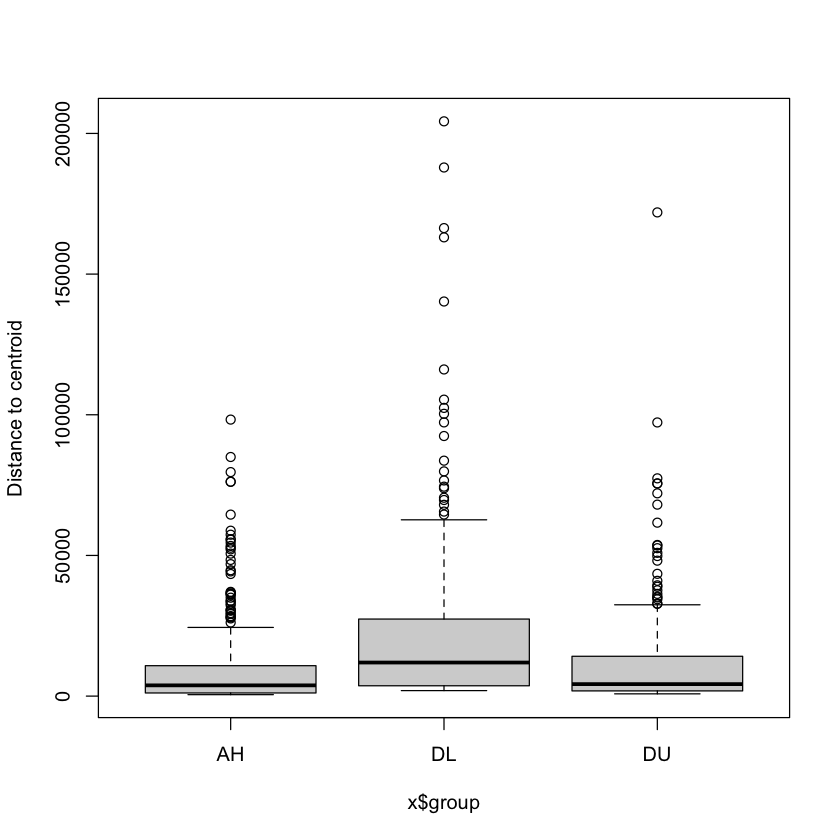

In [35]:
dis_clr <- vegdist(otu_table(t(ps.coral_TL_reef)), method ="euclidean")
# PERMDISP2 procedure for the analysis of multivariate homogeneity of group dispersions (variances).
mod_clr <- betadisper(dis_clr, sample_data(ps.coral_TL_reef)$tissue_type)
permutest(mod_clr, permutations = how(nperm=999))
TukeyHSD(mod_clr)
boxplot(mod_clr)

ps_clr_meta= as(sample_data(ps.coral_TL_reef), "data.frame")


adonis2(dis_clr~ tissue_type, 
       data =ps_clr_meta, permutations = 999, 
         method = "euclidean", block=Study)


pairwise.adonis(dis_clr, ps_clr_meta$tissue_type, sim.method = "euclidean",
                p.adjust.m = "bonferroni")


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
            Df     Sum Sq    Mean Sq      F N.Perm Pr(>F)    
Groups       2 2.9974e+11 1.4987e+11 56.797    999  0.001 ***
Residuals 1036 2.7337e+12 2.6387e+09                         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
           diff        lwr      upr     p adj
DL-AH 35303.139  27460.017 43146.26 0.0000000
DU-AH 27222.991   3532.854 50913.13 0.0194495
DU-DL -8080.148 -32101.529 15941.23 0.7095807


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
tissue_type,2,1.497634e+11,0.03374707,18.09152,0.001
Residual,1036,4.288056e+12,0.96625293,NA,NA
Total,1038,4.437819e+12,1.00000000,NA,NA


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
AH vs DL,1,135242299344,33.11911,0.031750079,0.001,0.003,*
AH vs DU,1,21172379399,10.37162,0.015448410,0.001,0.003,*
DL vs DU,1,11666706210,1.50797,0.003746435,0.151,0.453,


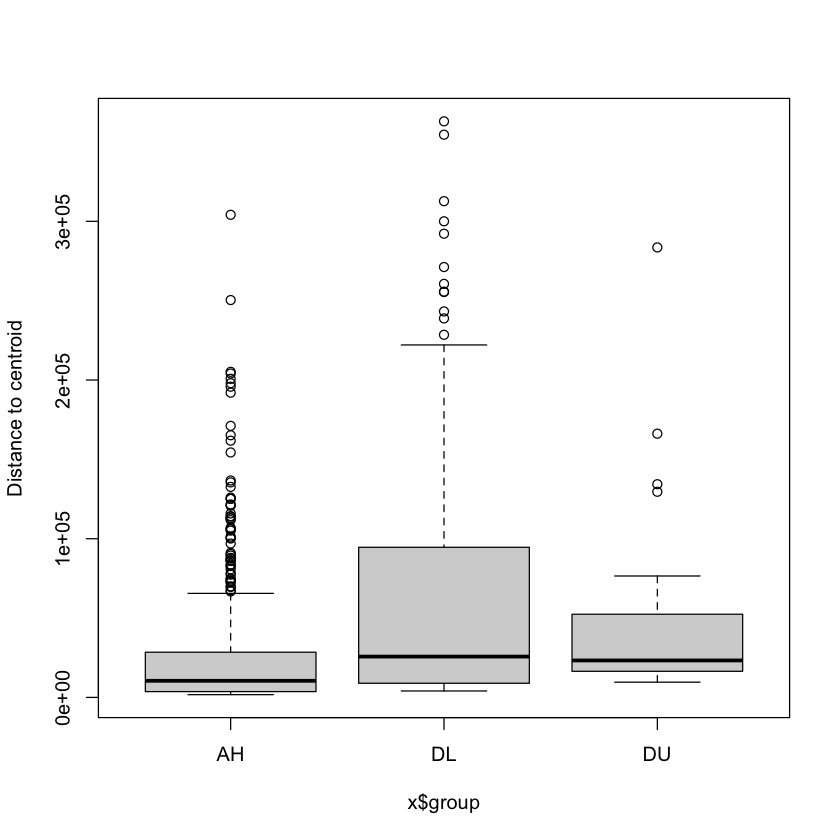

In [36]:
dis_clr <- vegdist(otu_table(t(ps.coral_TL_meso)), method ="euclidean")
# PERMDISP2 procedure for the analysis of multivariate homogeneity of group dispersions (variances).
mod_clr <- betadisper(dis_clr, sample_data(ps.coral_TL_meso)$tissue_type)
permutest(mod_clr, permutations = how(nperm=999))
TukeyHSD(mod_clr)
boxplot(mod_clr)


ps_clr_meta= as(sample_data(ps.coral_TL_meso), "data.frame")


adonis2(dis_clr~ tissue_type, 
       data =ps_clr_meta, permutations = 999, 
         method = "euclidean", block=Study)


pairwise.adonis(dis_clr, ps_clr_meta$tissue_type, sim.method = "euclidean",
                p.adjust.m = "bonferroni")


	Homogeneity of multivariate dispersions

Call: betadisper(d = dis_clr, group =
sample_data(ps.coral)$tissue_type)

No. of Positive Eigenvalues: 204
No. of Negative Eigenvalues: 0

Average distance to median:
   AH    DL    DU 
16104 39750 13808 

Eigenvalues for PCoA axes:
(Showing 8 of 204 eigenvalues)
    PCoA1     PCoA2     PCoA3     PCoA4     PCoA5     PCoA6     PCoA7     PCoA8 
1.058e+12 7.023e+11 3.599e+11 2.422e+11 1.621e+11 1.342e+11 1.035e+11 8.418e+10 


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
            Df     Sum Sq    Mean Sq     F N.Perm Pr(>F)    
Groups       2 2.5080e+11 1.2540e+11 91.98    999  0.001 ***
Residuals 1934 2.6367e+12 1.3633e+09                        
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
            diff       lwr        upr     p adj
DL-AH  23645.978  19226.51  28065.444 0.0000000
DU-AH  -2295.266  -7838.10   3247.568 0.5951531
DU-DL -25941.244 -31854.26 -20028.228 0.0000000


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
tissue_type,2,1.162106e+11,0.02982965,29.73218,0.001
Residual,1934,3.779598e+12,0.97017035,NA,NA
Total,1936,3.895809e+12,1.00000000,NA,NA


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
AH vs DU,1,7236291291,8.748108,0.006663965,0.001,0.003,*
AH vs DL,1,100474137208,46.320284,0.027965777,0.001,0.003,*
DU vs DL,1,56155933542,17.927686,0.018445494,0.001,0.003,*


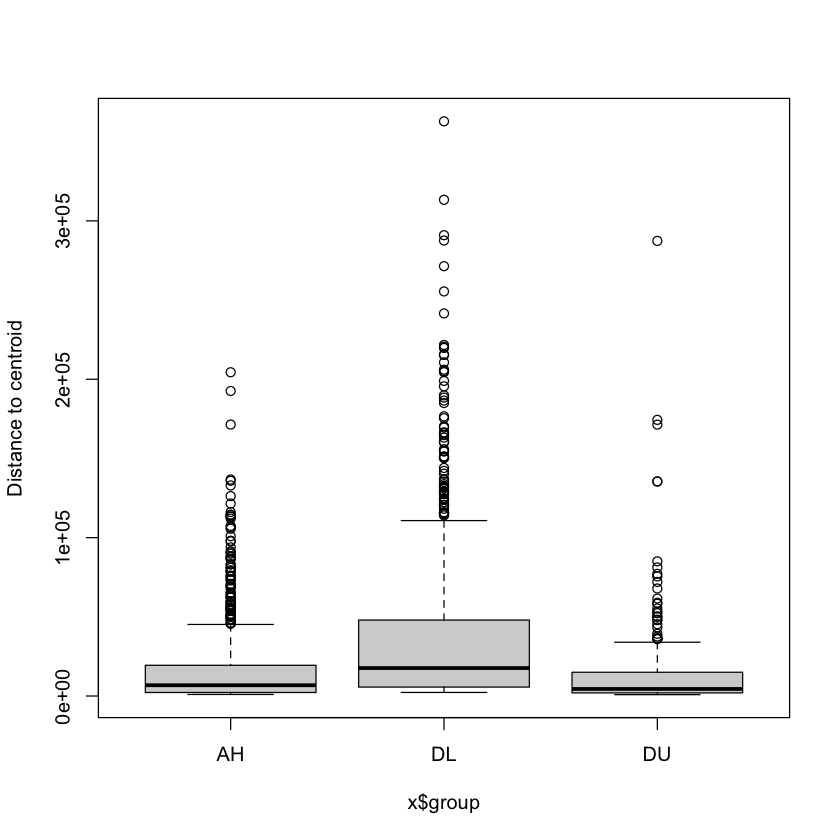

In [38]:
dis_clr <- vegdist(otu_table(t(ps.coral)), method ="euclidean")
# PERMDISP2 procedure for the analysis of multivariate homogeneity of group dispersions (variances).
mod_clr <- betadisper(dis_clr, sample_data(ps.coral)$tissue_type)
mod_clr
#permutest(mod_clr, pairwise = TRUE, permutations = 999)
boxplot(mod_clr)
permutest(mod_clr, permutations = how(nperm=999))
TukeyHSD(mod_clr)


ps_clr_meta= as(sample_data(ps.coral), "data.frame")


adonis2(dis_clr~ tissue_type, 
       data =ps_clr_meta, permutations = 999, 
         method = "euclidean", block=Study)


pairwise.adonis(dis_clr, ps_clr_meta$tissue_type, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
                                   diff        lwr        upr     p adj
USA:FTL-USA:FLKeys           -31690.678 -38502.884 -24878.473 0.0000000
USA:Miami-USA:FLKeys         -25958.630 -31778.797 -20138.462 0.0000000
USA:VirginIslands-USA:FLKeys  -9045.774 -14694.768  -3396.779 0.0002334
USA:Miami-USA:FTL              5732.049  -2093.813  13557.910 0.2355156
USA:VirginIslands-USA:FTL     22644.905  14945.497  30344.313 0.0000000
USA:VirginIslands-USA:Miami   16912.856  10075.525  23750.187 0.0000000


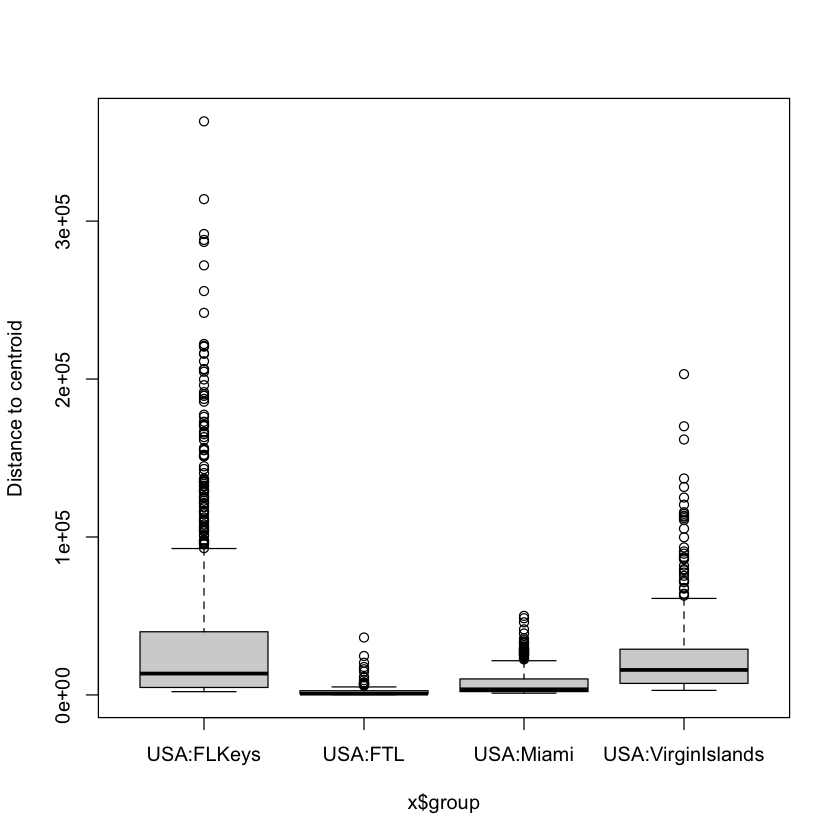

In [39]:
#dis_clr <- vegdist(otu_table(t(ps.coral)), method ="euclidean")
# PERMDISP2 procedure for the analysis of multivariate homogeneity of group dispersions (variances).
mod_clr <- betadisper(dis_clr, sample_data(ps.coral)$country)
TukeyHSD(mod_clr)
boxplot(mod_clr)


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
            Df     Sum Sq    Mean Sq      F N.Perm Pr(>F)    
Groups       1 1.6695e+11 1.6695e+11 118.08    999  0.001 ***
Residuals 1935 2.7358e+12 1.4139e+09                         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Biome,1,6.925644e+10,0.01777717,35.0214,0.001
Residual,1935,3.826552e+12,0.98222283,NA,NA
Total,1936,3.895809e+12,1.00000000,NA,NA


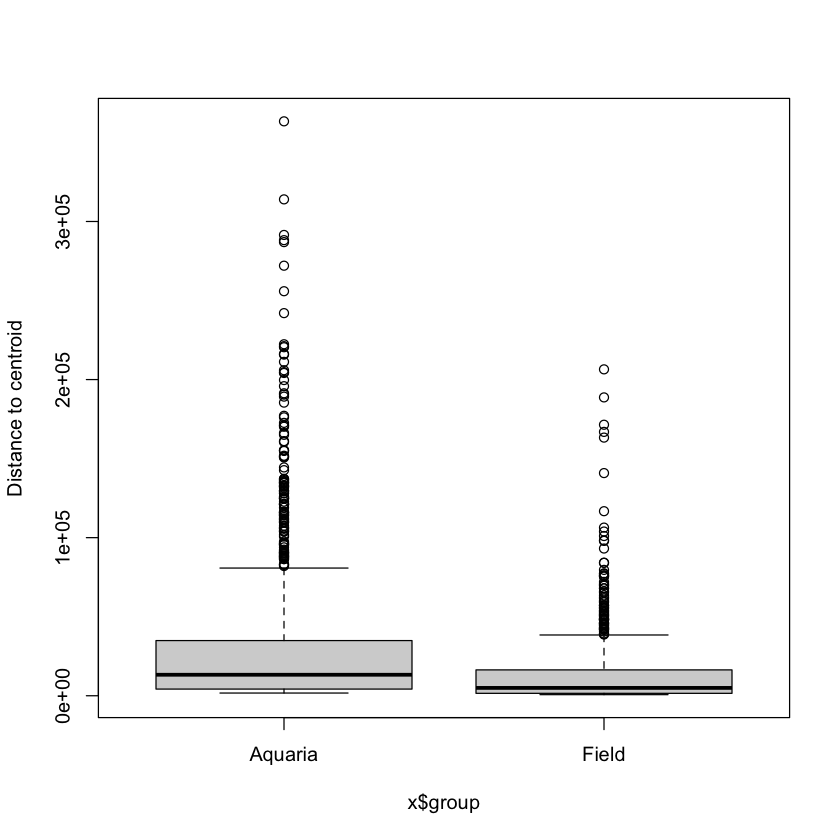

In [40]:
#dis_clr <- vegdist(otu_table(t(ps.coral)), method ="euclidean")
# PERMDISP2 procedure for the analysis of multivariate homogeneity of group dispersions (variances).
mod_clr <- betadisper(dis_clr, sample_data(ps.coral)$Biome)

boxplot(mod_clr)
permutest(mod_clr, permutations = how(nperm=999))

adonis2(dis_clr~Biome, 
       data =ps_clr_meta, permutations = 999, 
         method = "euclidean", block=Study)




  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
                                                                   diff
CS1_515F_CS2_806R-AA515F_archaea806R                         -38343.251
Pr515_806RAp-AA515F_archaea806R                              -26418.576
S_D_Bact_0341_b_S_17_S_D_Bact_0785_a_A_21-AA515F_archaea806R -34460.767
Pr515_806RAp-CS1_515F_CS2_806R                                11924.675
S_D_Bact_0341_b_S_17_S_D_Bact_0785_a_A_21-CS1_515F_CS2_806R    3882.484
S_D_Bact_0341_b_S_17_S_D_Bact_0785_a_A_21-Pr515_806RAp        -8042.191
                                                                    lwr
CS1_515F_CS2_806R-AA515F_archaea806R                         -49303.074
Pr515_806RAp-AA515F_archaea806R                              -30810.500
S_D_Bact_0341_b_S_17_S_D_Bact_0785_a_A_21-AA515F_archaea806R -51459.050
Pr515_806RAp-CS1_515F_CS2_806R                                 1097.142
S_D

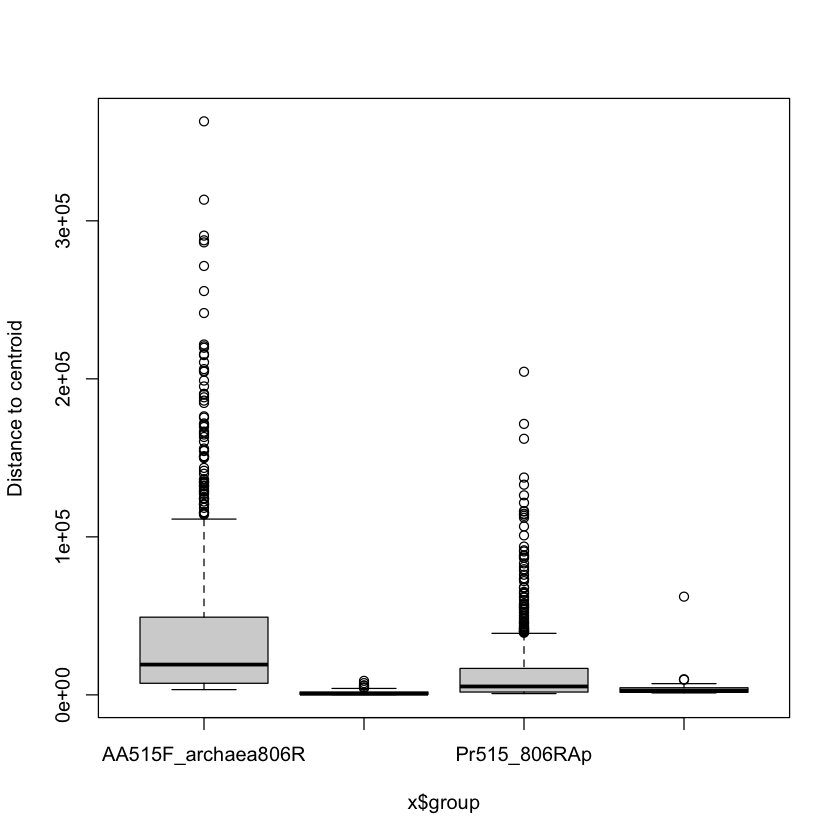

In [16]:
# PERMDISP2 procedure for the analysis of multivariate homogeneity of group dispersions (variances).
mod_clr <- betadisper(dis_clr, sample_data(ps.coral)$primer_names)
TukeyHSD(mod_clr)
boxplot(mod_clr)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
                 diff         lwr        upr     p adj
DLAB-CNAT  -7839.1314 -20901.0035  5222.7407 0.7391811
DSTO-CNAT -12729.9397 -31974.5226  6514.6431 0.5956850
MCAV-CNAT  11854.4746   1910.5246 21798.4246 0.0052984
MMEA-CNAT    520.6544 -16300.9709 17342.2797 1.0000000
OANN-CNAT   8076.4784  -8573.7846 24726.7414 0.9274167
OFAV-CNAT  14250.9131   3595.2333 24906.5929 0.0006985
OFRA-CNAT  -2910.4879 -50382.9078 44561.9321 1.0000000
PAST-CNAT  23387.9552   4293.6577 42482.2527 0.0034354
PCLI-CNAT -16294.5180 -67455.4940 34866.4581 0.9978893
PSTR-CNAT  -1047.3945 -12652.3828 10557.5938 1.0000000
SINT-CNAT  -6897.6807 -33011.8657 19216.5043 0.9996733
SSID-CNAT   4832.3880  -8522.3477 18187.1238 0.9930940
DSTO-DLAB  -4890.8083 -24877.8774 15096.2609 0.9998527
MCAV-DLAB  19693.6061   8379.4068 31007.8054 0.0000007
MMEA-DLAB   8359.7859  -9306.4543 26026.02


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
            Df     Sum Sq    Mean Sq      F N.Perm Pr(>F)    
Groups      12 1.3585e+11 1.1321e+10 8.1511    999  0.001 ***
Residuals 1924 2.6721e+12 1.3888e+09                         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
species_code,12,2.808140e+11,0.07208105,12.45475,0.001
Residual,1924,3.614995e+12,0.92791895,NA,NA
Total,1936,3.895809e+12,1.00000000,NA,NA


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
TissueSlurry vs Mucus,1,33199025640,16.216032,0.008542775,0.001,0.003,*
TissueSlurry vs TissueSlurry_Skeleton,1,4958072219,2.181749,0.001412884,0.057,0.171,
Mucus vs TissueSlurry_Skeleton,1,2296221612,2.825457,0.006323402,0.033,0.099,


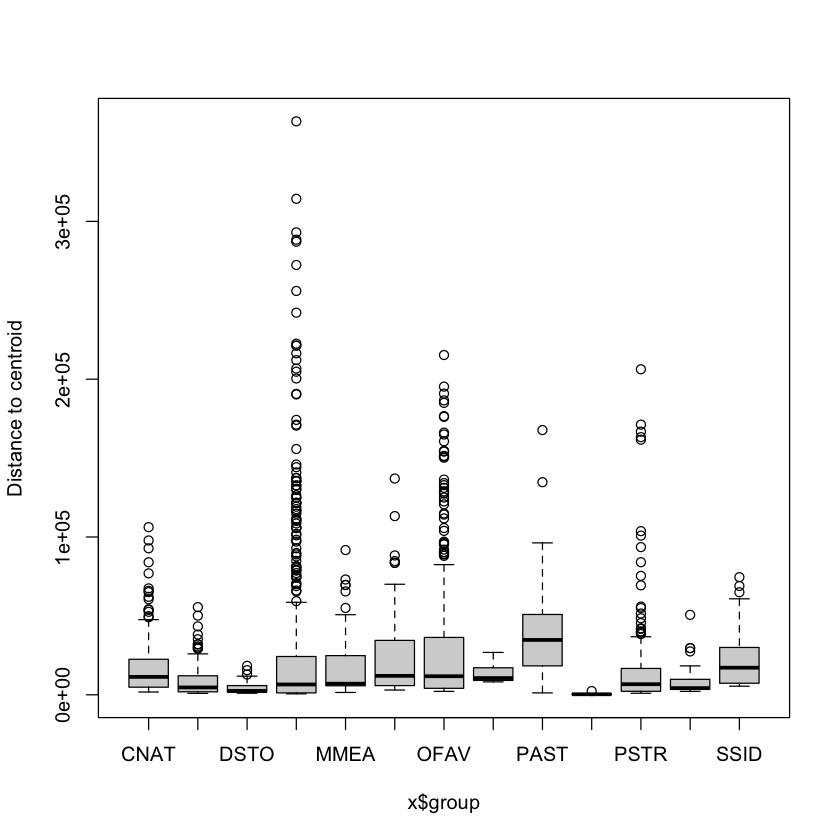

In [42]:
mod_clr <- betadisper(dis_clr, sample_data(ps.coral)$species_code)
TukeyHSD(mod_clr)
boxplot(mod_clr)

permutest(mod_clr, permutations = how(nperm=999))




adonis2(dis_clr~species_code, 
       data =ps_clr_meta, permutations = 999, 
         method = "euclidean", block=Study)


pairwise.adonis(dis_clr, ps_clr_meta$sample_type, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
                                         diff        lwr       upr     p adj
TissueSlurry-Mucus                  10729.013   5614.407 15843.618 0.0000028
TissueSlurry_Skeleton-Mucus         -9618.635 -22817.605  3580.334 0.2019229
TissueSlurry_Skeleton-TissueSlurry -20347.648 -32955.866 -7739.430 0.0004643



Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
            Df     Sum Sq    Mean Sq     F N.Perm Pr(>F)    
Groups       2 5.2708e+10 2.6354e+10 17.82    999  0.001 ***
Residuals 1934 2.8602e+12 1.4789e+09                        
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
                                         diff        lwr       upr     p adj
TissueSlurry-Mucus                  10729.013   5614.407 15843.618 0.0000028
TissueSlurry_Skeleton-Mucus         -9618.635 -22817.605  3580.334 0.2019229
TissueSlurry_Skeleton-TissueSlurry -20347.648 -32955.866 -7739.430 0.0004643


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
sample_type,2,3.677147e+10,0.009438726,9.214219,0.001
Residual,1934,3.859037e+12,0.990561274,NA,NA
Total,1936,3.895809e+12,1.000000000,NA,NA


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
TissueSlurry vs Mucus,1,33199025640,16.216032,0.008542775,0.001,0.003,*
TissueSlurry vs TissueSlurry_Skeleton,1,4958072219,2.181749,0.001412884,0.059,0.177,
Mucus vs TissueSlurry_Skeleton,1,2296221612,2.825457,0.006323402,0.032,0.096,


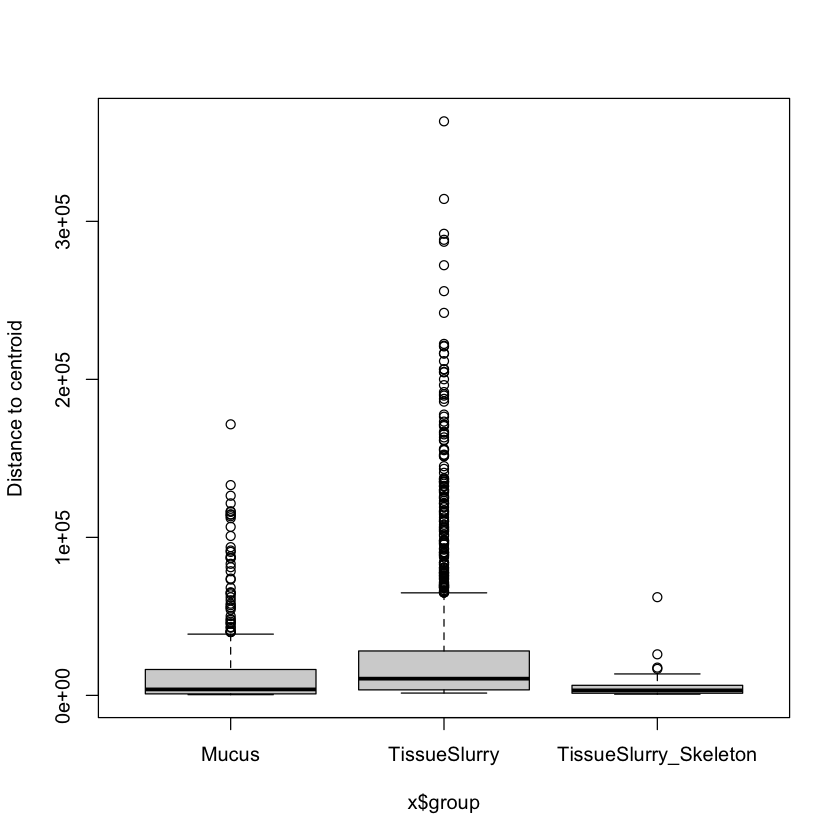

In [41]:
mod_clr <- betadisper(dis_clr, sample_data(ps.coral)$sample_type)
TukeyHSD(mod_clr)
boxplot(mod_clr)
permutest(mod_clr, permutations = how(nperm=999))




adonis2(dis_clr~sample_type, 
       data =ps_clr_meta, permutations = 999, 
         method = "euclidean", block=Study)


pairwise.adonis(dis_clr, ps_clr_meta$sample_type, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
                                                                diff
ENS_LBTS1-Breviolum                                       -6080.1441
EPA1-Breviolum                                             5111.7632
FloridaReefTract2017-Breviolum                            -3407.9653
JSEP_SCTLD_Endo-Breviolum                                 -1711.9918
LooeKey_2018-Breviolum                                    -1892.7787
SSIDDiseaseConchReef-Breviolum                            -5936.0629
StewartMedina_FL2019-Breviolum                            -6640.5720
SWGmicrobiome2018-Breviolum                               13984.3785
SWGTransmission-Breviolum                                 56172.8152
TransmissionExperimentMucus-Breviolum                     21191.6549
TransmissionExperimentTissue-Breviolum                    10391.5532
USVIFeb2020-Breviolum                  


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
            Df     Sum Sq    Mean Sq      F N.Perm Pr(>F)    
Groups      12 8.1959e+11 6.8300e+10 68.858    999  0.001 ***
Residuals 1924 1.9084e+12 9.9189e+08                         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Alias,12,3.802294e+11,0.09759961,17.34094,0.001
Residual,1924,3.515579e+12,0.90240039,NA,NA
Total,1936,3.895809e+12,1.00000000,NA,NA


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
USVIFeb2020 vs TransmissionExperimentMucus,1,9348949465,5.784187,0.023922933,0.002,0.156,
USVIFeb2020 vs TransmissionExperimentTissue,1,8410922122,8.950372,0.041639250,0.001,0.078,
USVIFeb2020 vs FloridaReefTract2017,1,4516246647,9.834863,0.082760759,0.001,0.078,
USVIFeb2020 vs EPA1,1,3139512155,5.194138,0.037049610,0.002,0.156,
USVIFeb2020 vs SWGmicrobiome2018,1,6892826848,5.707351,0.013729252,0.003,0.234,
USVIFeb2020 vs SWGTransmission,1,53413074379,8.032966,0.021082076,0.001,0.078,
USVIFeb2020 vs JSEP_SCTLD_Endo,1,2815238951,4.137471,0.056571149,0.005,0.390,
USVIFeb2020 vs SSIDDiseaseConchReef,1,1812761284,2.351783,0.038332763,0.049,1.000,
USVIFeb2020 vs LooeKey_2018,1,2789643501,3.735969,0.053573058,0.008,0.624,


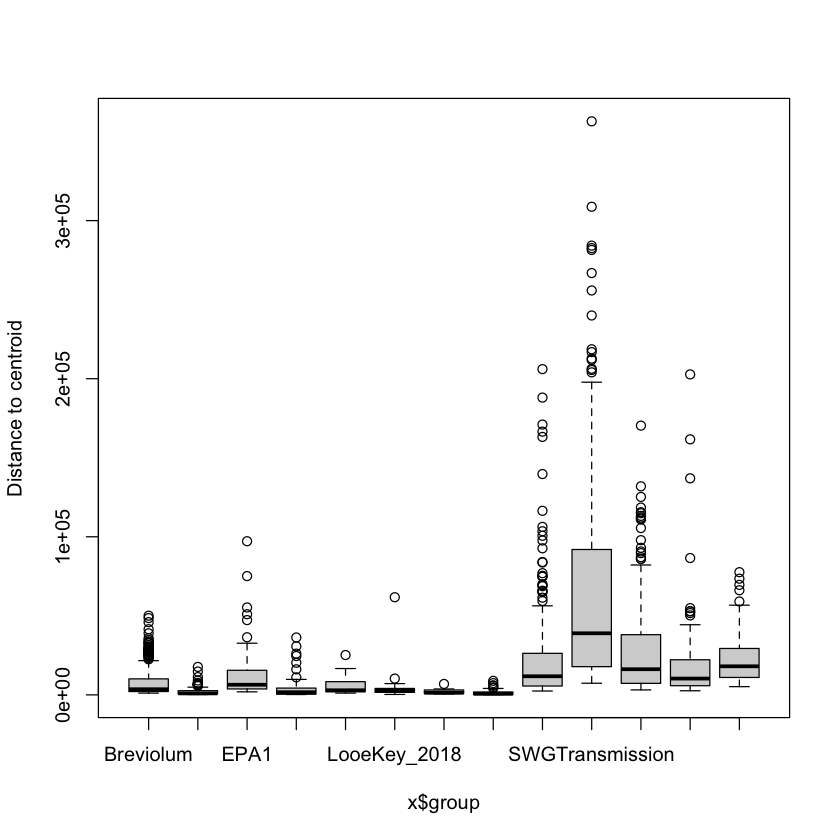

In [43]:
mod_clr <- betadisper(dis_clr, sample_data(ps.coral)$Alias)
TukeyHSD(mod_clr)
boxplot(mod_clr)
permutest(mod_clr, permutations = how(nperm=999))


adonis2(dis_clr~Alias, 
       data =ps_clr_meta, permutations = 999, 
         method = "euclidean")


pairwise.adonis(dis_clr, ps_clr_meta$Alias, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
                diff        lwr        upr     p adj
2017-2016  -5384.225 -45737.675  34969.225 0.9962446
2018-2016  10432.150 -28710.509  49574.808 0.9501149
2019-2016  22914.747 -16081.630  61911.123 0.4946863
2020-2016   1044.616 -38136.088  40225.320 0.9999936
2018-2017  15816.374   3932.692  27700.057 0.0026506
2019-2017  28298.972  16906.360  39691.583 0.0000000
2020-2017   6428.841  -5579.563  18437.245 0.5875972
2019-2018  12482.597   6691.365  18273.829 0.0000000
2020-2018  -9387.533 -16312.023  -2463.044 0.0020528
2020-2019 -21870.131 -27913.161 -15827.100 0.0000000



Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
            Df     Sum Sq    Mean Sq      F N.Perm Pr(>F)    
Groups       4 1.8636e+11 4.6591e+10 32.867    999  0.001 ***
Residuals 1932 2.7387e+12 1.4176e+09                         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
collection_year,4,8.082243e+10,0.020746,10.2326,0.001
Residual,1932,3.814986e+12,0.979254,NA,NA
Total,1936,3.895809e+12,1.000000,NA,NA


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2020 vs 2019,1,40015412306,16.5436693,0.0119402006,0.001,0.01,*
2020 vs 2017,1,1207844778,5.2027214,0.0102576764,0.005,0.05,.
2020 vs 2018,1,13518136082,19.6021235,0.0217173470,0.001,0.01,*
2020 vs 2016,1,547390768,2.0495185,0.0048561091,0.101,1.00,
2019 vs 2017,1,12628873482,4.1095502,0.0039246612,0.005,0.05,.
2019 vs 2018,1,49831825453,19.1909999,0.0132976161,0.001,0.01,*
2019 vs 2016,1,1697960113,0.5097867,0.0005301939,0.518,1.00,
2017 vs 2018,1,4347242886,4.8155409,0.0085713914,0.001,0.01,*
2017 vs 2016,1,687739527,10.6535940,0.1017986446,0.001,0.01,*


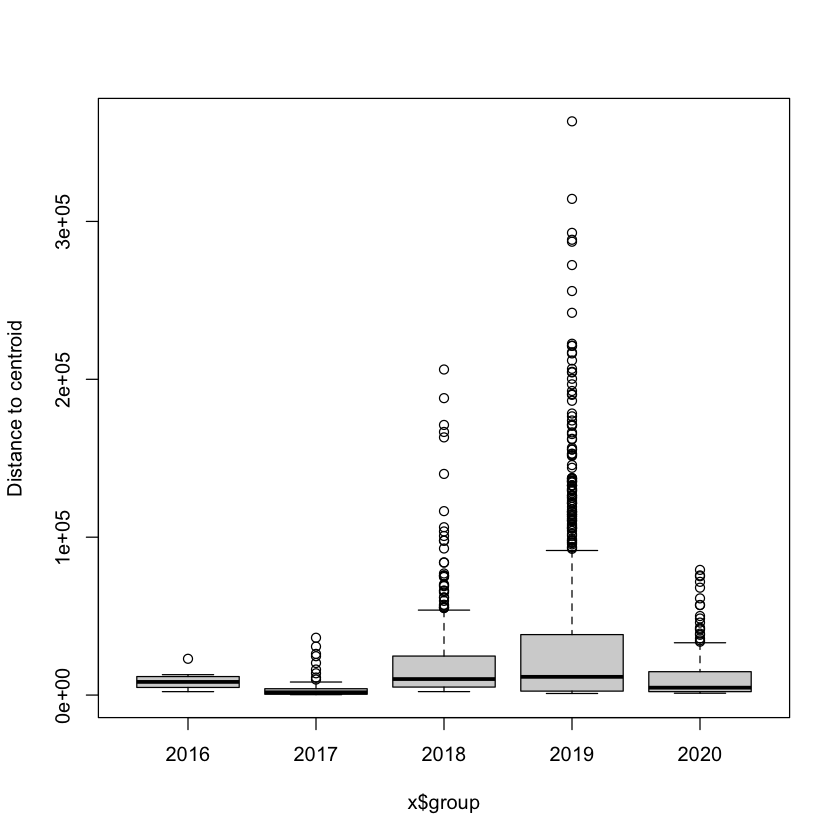

In [44]:
mod_clr <- betadisper(dis_clr, sample_data(ps.coral)$collection_year)
TukeyHSD(mod_clr)
boxplot(mod_clr)


permutest(mod_clr, permutations = how(nperm=999))


adonis2(dis_clr~collection_year, 
       data =ps_clr_meta, permutations = 999, 
         method = "euclidean", block=Study)


pairwise.adonis(dis_clr, ps_clr_meta$collection_year, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

In [22]:
ps_clr_df=as.data.frame(otu_table(ps.coral_clr))
ps_clr_meta= as(sample_data(ps.coral_clr), "data.frame")

In [23]:
ps_clr_meta_edit = ps_clr_meta %>% 
#as.tibble() %>% 
#dplyr::rename("Biome" = environment_.biome.) %>% 
dplyr::rename("Dissease.Status" = tissue_type) %>%
dplyr::rename("Sample.Type" = sample_type) %>%
dplyr::rename("Coral.Species" = species_code) %>%
dplyr::rename("Year" = collection_year) %>%
dplyr::rename("Zone" = SCTLD_status) %>%
dplyr::rename("Primers" = primer_names)
head(ps_clr_meta_edit)

,SampleID,BioSample,Run,SRA_accession,Lab,Experiment,Alias,Study,Collection_ID,Species_counts,⋯,Primers,forwardPrimer,ReversePrimer,linkerPrimerSequence,platform,platformChemistry,sequencing_facility,barcodes,basepairs,notes
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
102tiss_S3,102tiss_S3,TBD,Run1_BPC29622-1521,TBD,Apprill,FieldSampling_SCTLD_USVI_Feb2020,USVIFeb2020,USVI:2021Becker_etal,102tiss,Low,⋯,Pr515_806RAp,GTGYCAGCMGCCGCGGTAA,GGACTACNVGGGTWTCTAAT,TBD,Illumina,iSeq100i1,"HomeRentalonSt.Thomas,USVI",NA,150,NA
220tiss_S33,220tiss_S33,TBD,Run1_BPC29622-1521,TBD,Apprill,FieldSampling_SCTLD_USVI_Feb2020,USVIFeb2020,USVI:2021Becker_etal,220tiss,High,⋯,Pr515_806RAp,GTGYCAGCMGCCGCGGTAA,GGACTACNVGGGTWTCTAAT,TBD,Illumina,iSeq100i1,"HomeRentalonSt.Thomas,USVI",NA,150,NA
222tiss_S34,222tiss_S34,TBD,Run1_BPC29622-1521,TBD,Apprill,FieldSampling_SCTLD_USVI_Feb2020,USVIFeb2020,USVI:2021Becker_etal,222tiss,High,⋯,Pr515_806RAp,GTGYCAGCMGCCGCGGTAA,GGACTACNVGGGTWTCTAAT,TBD,Illumina,iSeq100i1,"HomeRentalonSt.Thomas,USVI",NA,150,NA
225tis_S40,225tis_S40,TBD,Run1_BPC29622-1521,TBD,Apprill,FieldSampling_SCTLD_USVI_Feb2020,USVIFeb2020,USVI:2021Becker_etal,225tis,High,⋯,Pr515_806RAp,GTGYCAGCMGCCGCGGTAA,GGACTACNVGGGTWTCTAAT,TBD,Illumina,iSeq100i1,"HomeRentalonSt.Thomas,USVI",NA,150,NA
232tiss_S41,232tiss_S41,TBD,Run1_BPC29622-1521,TBD,Apprill,FieldSampling_SCTLD_USVI_Feb2020,USVIFeb2020,USVI:2021Becker_etal,232tiss,High,⋯,Pr515_806RAp,GTGYCAGCMGCCGCGGTAA,GGACTACNVGGGTWTCTAAT,TBD,Illumina,iSeq100i1,"HomeRentalonSt.Thomas,USVI",NA,150,NA
262tiss_S35,262tiss_S35,TBD,Run1_BPC29622-1521,TBD,Apprill,FieldSampling_SCTLD_USVI_Feb2020,USVIFeb2020,USVI:2021Becker_etal,262tiss,High,⋯,Pr515_806RAp,GTGYCAGCMGCCGCGGTAA,GGACTACNVGGGTWTCTAAT,TBD,Illumina,iSeq100i1,"HomeRentalonSt.Thomas,USVI",NA,150,NA


In [24]:
 p <- pca(ps_clr_df, metadata = ps_clr_meta_edit, removeVar = 0.1)

-- removing the lower 10% of variables based on variance



In [25]:
?eigencorplot

Warning message in eigencorplot(p, metavars = c("Study", "Primers", "Biome", "Coral.Species", :
“Study is not numeric - please check the source data as non-numeric variables will be coerced to numeric”
Warning message in eigencorplot(p, metavars = c("Study", "Primers", "Biome", "Coral.Species", :
“Primers is not numeric - please check the source data as non-numeric variables will be coerced to numeric”
Warning message in eigencorplot(p, metavars = c("Study", "Primers", "Biome", "Coral.Species", :
“Biome is not numeric - please check the source data as non-numeric variables will be coerced to numeric”
Warning message in eigencorplot(p, metavars = c("Study", "Primers", "Biome", "Coral.Species", :
“Coral.Species is not numeric - please check the source data as non-numeric variables will be coerced to numeric”
Warning message in eigencorplot(p, metavars = c("Study", "Primers", "Biome", "Coral.Species", :
“Dissease.Status is not numeric - please check the source data as non-numeric variable

Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = cor

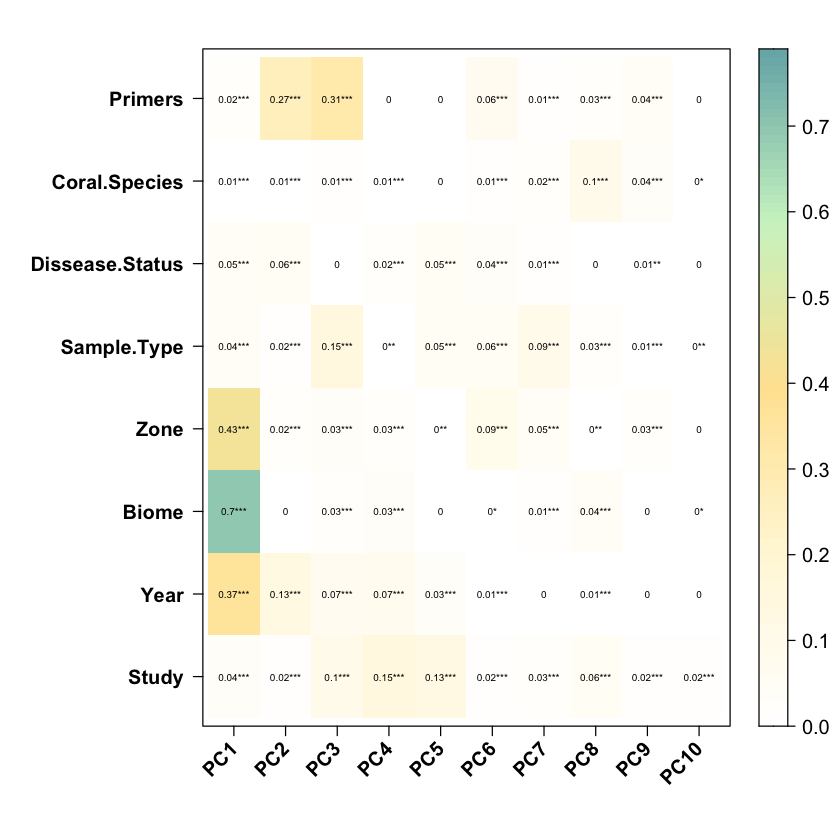

In [26]:
 eigencorplot(p,
    metavars = c("Study", "Primers", "Biome", "Coral.Species", 
                 "Dissease.Status", "Sample.Type", "Year", "Zone"),
              col = c('white', 'cornsilk1', "#FFE4A1",  '#CFF3CA', "#77B3B5"),
    cexCorval = 0.5,
    fontCorval = 0.5,
    cexTitleX = 4,
    
    #posLab = 'all',
    rotLabX = 45,
    scale = TRUE,
    plotRsquared = TRUE,
    corFUN = 'spearman',
    corUSE = 'pairwise.complete.obs',
    corMultipleTestCorrection = 'BH')

In [27]:
ps_clr_df_meso=as.data.frame(otu_table(ps.coral_TL_meso_CLR))
ps_clr_meta_meso= as(sample_data(ps.coral_TL_meso_CLR), "data.frame")

ps_clr_df_reef=as.data.frame(otu_table(ps.coral_TL_reef_CLR))
ps_clr_meta_reef= as(sample_data(ps.coral_TL_reef_CLR), "data.frame")